In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
cwd = os.getcwd()
import copy
import os
import warnings
cwd = os.getcwd()
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_palette(sns.diverging_palette(220, 20, n=6))

SAVEPLOTS = False

SAVEDIR = "../plots/MeanFieldTMDnanoribbon"
if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)



# Some useful functions

In [8]:
# %load MeanFieldTMDnanoribbonLib

def fermi(e, mu, beta):
    '''
    For zero temperature, set beta = 99999
    '''
    if beta == 99999:
        return (e < mu).astype(int)
    else:
        return 1 / ( 1 + np.exp( beta * ( e - mu ) ) )
    
def iTriang(x, y, Nx, Ny):
    return Nx * y + x

def triangular(Nx, Ny, nOrb, hoppings):
    T = np.zeros((nOrb*Nx*Ny, nOrb*Nx*Ny))
    for x in range(Nx):
        for y in range(Ny):
            # Diagonal term
            T[ iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1) * nOrb,              iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1) * nOrb ]            = hoppings[0]
            
            # E1
            T[ iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1)*nOrb,              iTriang( (x + 1) % Nx , y, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y, Nx, Ny) + 1)*nOrb ]            = hoppings[1]
            
            # E4
            T[ iTriang( (x + 1) % Nx , y, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y, Nx, Ny) + 1)*nOrb              , iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb ] = hoppings[4]
            
            if y == 0:
                T[ iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,                  iTriang( x, 1, Nx, Ny)*nOrb:(iTriang( x, 1, Nx, Ny)+1)*nOrb ]                = hoppings[6]
                
                T[ iTriang(x, 1, Nx, Ny)*nOrb:(iTriang(x, 1, Nx, Ny)+1)*nOrb,                  iTriang( x, 0, Nx, Ny)*nOrb:(iTriang( x, 0, Nx, Ny)+1)*nOrb ]                = hoppings[3]
                
                # Periodic
                T[ iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,                  iTriang( x, Ny - 1, Nx, Ny)*nOrb:(iTriang( x, Ny - 1, Nx, Ny)+1)*nOrb ]                = hoppings[3]
                T[ iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb,                  iTriang( x, 0, Nx, Ny)*nOrb:(iTriang( x, 0, Nx, Ny)+1)*nOrb ]                = hoppings[6]
                
                T[ iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,                  iTriang( ( x + 1 ) % Nx, Ny - 1, Nx, Ny)*nOrb:(iTriang( ( x + 1 ) % Nx, Ny - 1, Nx, Ny)+1)*nOrb ]                = hoppings[2]
                T[iTriang( ( x + 1 ) % Nx, Ny - 1, Nx, Ny)*nOrb:(iTriang( ( x + 1 ) % Nx, Ny - 1, Nx, Ny)+1)*nOrb,                iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb]                = hoppings[5]
                
                #
                if x == 0:
                    T[iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny) + 1)*nOrb,                      iTriang( Nx - 1, 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, 1, Nx, Ny) + 1)*nOrb]                    = hoppings[5]
                    T[iTriang( Nx - 1, 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, 1, Nx, Ny)+1)*nOrb,                      iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb]                    = hoppings[2]
                else:
                    T[iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,                      iTriang( x - 1, 1, Nx, Ny)*nOrb:(iTriang( x - 1, 1, Nx, Ny)+1)*nOrb]                    = hoppings[5]
                    T[iTriang(x - 1, 1, Nx, Ny)*nOrb:(iTriang(x - 1, 1, Nx, Ny)+1)*nOrb,                      iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb]                    = hoppings[2]
            else:
                if y == Ny - 1:
                    T[iTriang(x, Ny - 1 , Nx, Ny)*nOrb:(iTriang(x, Ny - 1 , Nx, Ny) + 1)*nOrb,                      iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny) + 1)*nOrb]                    = hoppings[2]
                    T[iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)+1)*                      nOrb, iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb]                    = hoppings[5]
                    T[iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb,                      iTriang( x, Ny - 2, Nx, Ny)*nOrb:(iTriang( x, Ny - 2, Nx, Ny)+1)*nOrb]                    = hoppings[3]
                    T[iTriang(x, Ny - 2, Nx, Ny)*nOrb:(iTriang(x, Ny - 2, Nx, Ny)+1)*nOrb,                      iTriang( x, Ny - 1, Nx, Ny)*nOrb:(iTriang( x, Ny - 1, Nx, Ny)+1)*nOrb]                    = hoppings[6]
                    # Periodic 
                    T[iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb,                      iTriang( x, 0, Nx, Ny)*nOrb:(iTriang( x, 0, Nx, Ny)+1)*nOrb]                    = hoppings[6]
                    T[iTriang( x, 0, Nx, Ny)*nOrb:(iTriang( x, 0, Nx, Ny)+1)*nOrb,                      iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb]                    = hoppings[3]
                    if x == 0:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,                          iTriang( Nx - 1, 0, Nx, Ny)*nOrb:(iTriang( Nx - 1, 0, Nx, Ny)+1)*nOrb]                        = hoppings[5]
                        T[iTriang( Nx - 1, 0, Nx, Ny)*nOrb:(iTriang( Nx - 1, 0, Nx, Ny)+1)*nOrb,                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]                        = hoppings[2]
                    else:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,                          iTriang(x - 1, 0, Nx, Ny)*nOrb:(iTriang(x - 1, 0, Nx, Ny)+1)*nOrb]                        = hoppings[5]
                        T[iTriang(x - 1, 0, Nx, Ny)*nOrb:(iTriang(x - 1, 0, Nx, Ny)+1)*nOrb,                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]                        = hoppings[2]
                    #
                else:
                    T[iTriang(x, y , Nx, Ny)*nOrb:(iTriang(x, y , Nx, Ny)+1)*nOrb,                      iTriang( (x + 1) % Nx , y - 1, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y - 1, Nx, Ny)+1)*nOrb]                    = hoppings[2]
                    T[iTriang( (x + 1) % Nx , y - 1, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y - 1, Nx, Ny)+1)*nOrb,                      iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]                    = hoppings[5]
                    T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,                      iTriang( x, y - 1, Nx, Ny)*nOrb:(iTriang( x, y - 1, Nx, Ny)+1)*nOrb] = hoppings[3]
                    T[iTriang(x, y - 1, Nx, Ny)*nOrb:(iTriang(x, y - 1, Nx, Ny)+1)*nOrb,                      iTriang( x, y, Nx, Ny)*nOrb:(iTriang( x, y, Nx, Ny)+1)*nOrb] = hoppings[6]
                    if x == 0:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,                          iTriang( Nx - 1, y + 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, y + 1, Nx, Ny)+1)*nOrb]                        = hoppings[5]
                        T[iTriang( Nx - 1, y + 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, y + 1, Nx, Ny)+1)*nOrb,                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]                        = hoppings[2]
                    else:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,                          iTriang(x - 1, y + 1, Nx, Ny)*nOrb:(iTriang(x - 1, y + 1, Nx, Ny)+1)*nOrb]                        = hoppings[5]
                        T[iTriang(x - 1, y + 1, Nx, Ny)*nOrb:(iTriang(x - 1, y + 1, Nx, Ny)+1)*nOrb,                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]                        = hoppings[2]
    return T



def triangularNano(Nx, Ny, nOrb, hoppings):
    T = np.zeros((nOrb*Nx*Ny, nOrb*Nx*Ny))
    for x in range(Nx):
        for y in range(Ny):
            # Diagonal term
            T[ iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1) * nOrb,              iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1) * nOrb ]            = hoppings[0]
            
            # E1
            T[ iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1)*nOrb,              iTriang( (x + 1) % Nx , y, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y, Nx, Ny) + 1)*nOrb ]            = hoppings[1]
            
            # E4
            T[ iTriang( (x + 1) % Nx , y, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y, Nx, Ny) + 1)*nOrb              , iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb ] = hoppings[4]
            
            if y == 0:
                T[ iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,                  iTriang( x, 1, Nx, Ny)*nOrb:(iTriang( x, 1, Nx, Ny)+1)*nOrb ]                = hoppings[6]
                
                T[ iTriang(x, 1, Nx, Ny)*nOrb:(iTriang(x, 1, Nx, Ny)+1)*nOrb,                  iTriang( x, 0, Nx, Ny)*nOrb:(iTriang( x, 0, Nx, Ny)+1)*nOrb ]                = hoppings[3]
            
                if x == 0:
                    T[iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny) + 1)*nOrb,                      iTriang( Nx - 1, 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, 1, Nx, Ny) + 1)*nOrb]                    = hoppings[5]
                    T[iTriang( Nx - 1, 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, 1, Nx, Ny)+1)*nOrb,                      iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb]                    = hoppings[2]
                else:
                    T[iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,                      iTriang( x - 1, 1, Nx, Ny)*nOrb:(iTriang( x - 1, 1, Nx, Ny)+1)*nOrb]                    = hoppings[5]
                    T[iTriang(x - 1, 1, Nx, Ny)*nOrb:(iTriang(x - 1, 1, Nx, Ny)+1)*nOrb,                      iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb]                    = hoppings[2]
            else:
                if y == Ny - 1:
                    T[iTriang(x, Ny - 1 , Nx, Ny)*nOrb:(iTriang(x, Ny - 1 , Nx, Ny) + 1)*nOrb,                      iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny) + 1)*nOrb]                    = hoppings[2]
                    T[iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)+1)*                      nOrb, iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb]                    = hoppings[5]
                    T[iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb,                      iTriang( x, Ny - 2, Nx, Ny)*nOrb:(iTriang( x, Ny - 2, Nx, Ny)+1)*nOrb]                    = hoppings[3]
                    T[iTriang(x, Ny - 2, Nx, Ny)*nOrb:(iTriang(x, Ny - 2, Nx, Ny)+1)*nOrb,                      iTriang( x, Ny - 1, Nx, Ny)*nOrb:(iTriang( x, Ny - 1, Nx, Ny)+1)*nOrb]                    = hoppings[6]
                    
                else:
                    T[iTriang(x, y , Nx, Ny)*nOrb:(iTriang(x, y , Nx, Ny)+1)*nOrb,                      iTriang( (x + 1) % Nx , y - 1, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y - 1, Nx, Ny)+1)*nOrb]                    = hoppings[2]
                    T[iTriang( (x + 1) % Nx , y - 1, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y - 1, Nx, Ny)+1)*nOrb,                      iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]                    = hoppings[5]
                    T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,                      iTriang( x, y - 1, Nx, Ny)*nOrb:(iTriang( x, y - 1, Nx, Ny)+1)*nOrb] = hoppings[3]
                    T[iTriang(x, y - 1, Nx, Ny)*nOrb:(iTriang(x, y - 1, Nx, Ny)+1)*nOrb,                      iTriang( x, y, Nx, Ny)*nOrb:(iTriang( x, y, Nx, Ny)+1)*nOrb] = hoppings[6]
                    if x == 0:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,                          iTriang( Nx - 1, y + 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, y + 1, Nx, Ny)+1)*nOrb]                        = hoppings[5]
                        T[iTriang( Nx - 1, y + 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, y + 1, Nx, Ny)+1)*nOrb,                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]                        = hoppings[2]
                    else:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,                          iTriang(x - 1, y + 1, Nx, Ny)*nOrb:(iTriang(x - 1, y + 1, Nx, Ny)+1)*nOrb]                        = hoppings[5]
                        T[iTriang(x - 1, y + 1, Nx, Ny)*nOrb:(iTriang(x - 1, y + 1, Nx, Ny)+1)*nOrb,                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]                        = hoppings[2]
    return T

def plotTMD(nUp, nDown, energies, itSwitch, Nx, Ny, lastNit, lastIt, dotscale, magInsetLoc):
    fig = plt.figure(0)
    ax = fig.add_subplot(111)
    plt.xlabel(r'$i$')
    plt.ylabel(r'$\left \langle n_{i,\sigma} \right\rangle$')

    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    sns.set_palette(flatui)

    nUpSite = np.zeros(Nx * Ny)
    nDownSite = np.zeros(Nx * Ny)
    for i in range(Nx * Ny):    
        nUpSite[i] = nUp[nOrb * i] + nUp[nOrb * i + 1] + nUp[nOrb * i + 2]
        nDownSite[i] = nDown[nOrb * i] + nDown[nOrb * i + 1] + nDown[nOrb * i + 2]

    ax.plot(np.arange(Nx * Ny), nUpSite, color = "#e74c3c"            , label = r'$\left \langle n_{i,\uparrow} \right\rangle$',           linewidth = 1)
    ax.plot(np.arange(Nx * Ny), nDownSite, color = "#95a5a6"            , label = r'$\left \langle n_{i,\downarrow} \right\rangle$',           linewidth = 1)
    lgd = ax.legend(bbox_to_anchor=(1.05, 1),                    loc=2, borderaxespad=0.)
    if SAVEPLOTS == True:
        plt.savefig(SAVEDIR + SAVESUBDIR + "/densitiesTMD" + '.png',                    dpi = 600, bbox_extra_artists=(lgd,), bbox_inches='tight')

    plt.figure(1)
    plt.plot(nUpSite - nDownSite, color = "#e74c3c", linewidth = 1)
    plt.xlabel(r'$i$')
    plt.ylabel(r'$\left\langle m_{i} \right\rangle$')
    if SAVEPLOTS == True:
        plt.savefig(SAVEDIR + SAVESUBDIR + "/magnetizationTMD" + '.png', dpi = 600, bbox_inches='tight')

    plt.figure(2)
    plt.plot(abs(nUpSite - nDownSite), color = "#e74c3c", linewidth = 1)
    plt.xlabel(r'$i$')
    plt.ylabel(r'$| \left\langle m_{i} \right\rangle |$')
    if SAVEPLOTS == True:
        plt.savefig(SAVEDIR + SAVESUBDIR + "/AbsMagnetizationTMD" + '.png', dpi = 600, bbox_inches='tight')

    plt.figure(3)
    plt.plot(np.arange(energies[itSwitch:lastIt].size) + itSwitch, energies[itSwitch:lastIt], color = "#e74c3c", linewidth = 1)
    plt.xlabel('Iteration')
    plt.ylabel(r'$\Omega$')
    if SAVEPLOTS == True:
        plt.savefig(SAVEDIR + SAVESUBDIR + "/energyMFafterAnnealingTMD" + '.png', dpi = 600, bbox_inches='tight')


    plt.figure(4)
    plt.plot(np.arange(energies[:lastIt].size) , energies[:lastIt], color = "#e74c3c", linewidth = 1)
    plt.xlabel('Iteration')
    plt.ylabel(r'$\Omega$')
    if SAVEPLOTS == True:
        plt.savefig(SAVEDIR + SAVESUBDIR + "/energyMFtotalTMD" + '.png', dpi = 600, bbox_inches='tight')

    plt.figure(5)
    plt.plot(np.arange(energies[lastIt-lastNit:lastIt].size) + (lastIt - lastNit)             , energies[lastIt-lastNit:lastIt], color = "#e74c3c", linewidth = 1)
    plt.xlabel('Iteration')
    plt.ylabel(r'$\Omega$')
    if SAVEPLOTS == True:
        plt.savefig(SAVEDIR + SAVESUBDIR + "/energyMFlastNitTMD" + '.png', dpi = 600, bbox_inches='tight')
        
    clr = np.chararray((Nx * Ny), itemsize = 10)
        
    a1 = np.arange(Nx)
    a2 = np.arange(Ny)
    vs = np.zeros((Nx * Ny , 2))
    lat = np.zeros((Nx * Ny))
    v1 = np.array([1, 0])
    v2 = np.array([1 / 2, np.sqrt(3) / 2])
    for i in range(Nx):
        for j in range(Ny):
                vs[Nx * j + i, :] =                a1[i] * v1 + a2[j] * v2 
                lat[Nx * j + i]                =  dotscale * (nUpSite[Nx * j + i]                          - nDownSite[Nx * j + i] )
                if (nUpSite[Nx * j + i]                          - nDownSite[Nx * j + i] ) < 0 :
                    clr[Nx * j + i] = "#95a5a6"
                else:
                    clr[Nx * j + i] = "#e74c3c"

    fig = plt.figure(6)
    ax = fig.add_subplot(111)
    ax.scatter(vs[:, 0], vs[:, 1], s = abs(lat),               c = clr.decode('UTF-8'), alpha = 0.8, edgecolors = None)
    ax.axis('equal')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if SAVEPLOTS == True:
        plt.savefig(SAVEDIR + SAVESUBDIR + "/MFnanoribbonTMD.png", dpi = 600)
        
    fig = plt.figure(7)
    ax = fig.add_subplot(111)
    spins = nUpSite - nDownSite
    spinProf = np.zeros(Ny)
    for i in range(Nx * Ny):
        if (i+1) % Nx:
            spinProf[int((i+1) /  Nx)] = spins[i]
    ax.plot(np.arange(Ny), spinProf, c = "#e74c3c", linewidth = 0.5, marker = 'o', markersize = 3)
    plt.xlabel('y')
    plt.ylabel(r'$\left\langle m_y \right\rangle$')
    axins = inset_axes(ax, width=3, height=1.2, loc=magInsetLoc)
    axins.tick_params(labelleft = False)
    axins.set_xlabel(r'$i$')
    axins.set_ylabel(r'$\left\langle m_i \right\rangle$')
    axins.yaxis.set_label_position("right")
    axins.plot(spins,c = "#95a5a6", linewidth = 1)
    if SAVEPLOTS == True:
        plt.savefig(SAVEDIR + SAVESUBDIR +"/magProf.png", dpi = 500, bbox_inches='tight')
    
    fig = plt.figure(8)
    ax = fig.add_subplot(111)
    ax.plot(np.arange(energies[itSwitch:lastIt].size) + itSwitch,             energies[itSwitch:lastIt], color = "#e74c3c", linewidth = 1)
    plt.xlabel('Iteration')
    plt.ylabel(r'$\Omega$')
    plt.xlim(40, lastIt+25)
    axins1 = inset_axes(ax, width=1.5, height=1., loc=1)
    axins2 = inset_axes(ax, width=1.5, height=1., loc=4)
    axins1.set_xlabel('Iteration')
    axins1.set_ylabel(r'$\Omega$')
    axins1.plot(np.arange(energies[:lastIt].size),               energies[:lastIt], color = "#e74c3c", linewidth = 1)
    axins2.plot(np.arange(energies[lastIt-lastNit:lastIt].size) + (lastIt - lastNit)         , energies[lastIt-lastNit:lastIt], color = "#e74c3c", linewidth = 1)
    axins2.tick_params(labelbottom=False)
    if SAVEPLOTS == True:
        plt.savefig(SAVEDIR + SAVESUBDIR +"/grandPotMin.png", dpi = 500, bbox_inches='tight')

def Hribbon(k, Ny):
    Hrib = np.zeros((3 * Ny, 3 * Ny), dtype=np.complex64)
    
    h1 = np.array([
        
        [e1 + 2 * t0 * np.cos(k),
                    2.j * np.sin(k) * t1,
                    2 * t2 * np.cos(k)],
                   
              [-2.j * np.sin(k) * t1,
               e2 + 2 * t11 * np.cos(k),
               2.j * np.sin(k) * t12],
                   
              [2 * t2 * np.cos(k),
               -2.j * np.sin(k) * t12,
               e2 + 2 * t22 * np.cos(k)]
    
    ], dtype=np.complex64)

    h2 = np.array([
        
        [ 2 * t0 * np.cos(k/2) ,
         1.j * np.sin(k/2) * ( t1 - np.sqrt(3) * t2 ) ,
         -1. * np.cos(k/2) * ( np.sqrt(3) * t1 + t2 )] ,
        
              [ -1.j * np.sin(k/2) * ( t1 + np.sqrt(3) * t2 ),
               0.5 * np.cos(k/2) * ( t11 + 3 * t22 ),
               1.j * np.sin(k/2) * ( np.sqrt(3) / 2 * ( t22 - t11 ) - 2 * t12 ) ],
        
              [ np.cos(k/2) * ( np.sqrt(3) * t1 - t2 ),
               1.j * np.sin(k/2) * ( np.sqrt(3)/2 * ( t22 - t11 ) + 2 * t12 ),
               0.5 * np.cos(k/2) * ( 3 * t11 + t22 ) ]
    
    ], dtype=np.complex64)
    
    for y in range(1, Ny-1):
        Hrib[3*y:3*(y+1), 3*y:3*(y+1)] = h1
        Hrib[3*(y-1):3*y, 3*y:3*(y+1)] = (h2.conj()).T
        Hrib[3*(y+1):3*(y+2), 3*y:3*(y+1)] = h2

    Hrib[0:3, 0:3] = h1
    Hrib[3*(Ny-1):3*(Ny), 3*(Ny-1):3*(Ny)] = h1
    Hrib[3*(Ny-2):3*(Ny-1), 3*(Ny-1):3*Ny] = (h2.conj()).T
    Hrib[3:6, 0:3] = h2
    
    return Hrib



# Define the model

In [9]:
nOrb = 3
Nx = 16
Ny = 8

abs_t0 = 0.184

e1 = 1.046 / abs_t0
e2 = 2.104 / abs_t0
t0 = - 1
t1 = 0.401 / abs_t0
t2 = 0.507 / abs_t0
t11 = 0.218 / abs_t0
t12 = 0.338 / abs_t0
t22 = 0.057 / abs_t0

E0 = np.array([[e1, 0, 0],
               [0, e2, 0],
               [0, 0, e2]])

E1 = np.array([[t0, t1, t2],
               [-t1, t11, t12],
               [t2, -t12, t22]])

E4 = np.array([[t0, -t1, t2],
               [t1, t11, -t12],
               [t2, t12, t22]])

E2 = np.array([[t0, 0.5 * t1 - np.sqrt(3) / 2 * t2, - np.sqrt(3) / 2 * t1 - 0.5 * t2],
               [-0.5 * t1 - np.sqrt(3) / 2 * t2, 0.25 * ( t11 + 3 * t22 ), np.sqrt(3) / 4 * ( t22 - t11 ) - t12],
               [np.sqrt(3) / 2 * t1 - 0.5 * t2, np.sqrt(3) / 4 * ( t22 - t11 ) + t12, ( 3 * t11 + t22) / 4 ]])

E5 = np.array([[t0, - 0.5 * t1 - np.sqrt(3) / 2 * t2, np.sqrt(3) / 2 * t1 - 0.5 * t2],
               [0.5 * t1 - np.sqrt(3) / 2 * t2, 0.25 * ( t11 + 3 * t22 ), np.sqrt(3) / 4 * ( t22 - t11 ) + t12],
               [-np.sqrt(3) / 2 * t1 - 0.5 * t2, np.sqrt(3) / 4 * ( t22 - t11 ) - t12, ( 3 * t11 + t22) / 4 ]])

E3 = np.array([[t0, - 0.5 * t1 + np.sqrt(3) / 2 * t2, -np.sqrt(3) / 2 * t1 - 0.5 * t2],
               [0.5 * t1 + np.sqrt(3) / 2 * t2, 0.25 * ( t11 + 3 * t22 ), -np.sqrt(3) / 4 * ( t22 - t11 ) + t12],
               [np.sqrt(3) / 2 * t1 - 0.5 * t2, -np.sqrt(3) / 4 * ( t22 - t11 ) - t12, ( 3 * t11 + t22) / 4 ]])

E6 = np.array([[t0, 0.5 * t1 + np.sqrt(3) / 2 * t2, np.sqrt(3) / 2 * t1 - 0.5 * t2],
               [-0.5 * t1 + np.sqrt(3) / 2 * t2, 0.25 * ( t11 + 3 * t22 ), -np.sqrt(3) / 4 * ( t22 - t11 ) - t12],
               [-np.sqrt(3) / 2 * t1 - 0.5 * t2, -np.sqrt(3) / 4 * ( t22 - t11 ) + t12, ( 3 * t11 + t22) / 4 ]])

hoppings = np.array([E0, E1, E2, E3, E4, E5, E6])

# Solve the self consistent equation in real space

In [ ]:
orbitalHoppingsNano = triangularNano(Nx, Ny, nOrb, hoppings)

N = nOrb * Nx * Ny # number of sites
beta0 = 1.1 # must be > 1, otherwise beta decreases
betaTarget = 20 # 99999 means infty ( T = 0 )
beta = beta0 # beta starts as beta0
inftyCutOff = 100 # above it, beta is practically infinity
t = 1 # hopping normalized to one
U = 8 # on-site interaction
muPHS = 3.3 # chemical potential
mu = ( muPHS + U / 2 ) # corresponding Fermi energy not in PHS form

itMax = 60
it = 0
lbda = 0.5 / (1.2 * itMax) # the factor multiplied by itMax impedes P ( I ) < \delta
itSwitch = 0
dampFreq = 1
# lbda is a parameter that reduces weight
# on the density obtained in the previous iteration 

#K = oneDimensionalChain(N)
K = - orbitalHoppingsNano

# Set a seed for the random initial condition case
np.random.seed(1)

# AF initial condition

#nUp = np.array([1 , 0])
#for i in range(int(N/2) - 1):
#    nUp = np.concatenate((nUp, np.array([1, 0]) ))

#nDown = np.array([0, 1])
#for i in range(int(N/2) - 1):
#    nDown = np.concatenate((nDown, np.array([0, 1]) ))

# F initial condition

nUp = np.ones(N) - 0.01 * np.random.rand(N)

nDown = np.zeros(N) + 0.01 * np.random.rand(N)

# Hybrid initial condition

#nUp = np.zeros(N)
#nDown = np.zeros(N)

#spinFlipper = 0.5

#for i in range(N):
#    if (i+1) % (3 * Nx) == 0:
#        spinFlipper *= -1
#    nUp[i] = 0.5 + spinFlipper
#    nDown[i] = 0.5 - spinFlipper

# Initialize energies
energies = np.zeros(itMax)

# Tolerance

delta = 1e-20

deltaUp = delta + 1
deltaDown = delta + 1

while (it < itMax and \
      deltaUp > delta and\
      deltaDown > delta): # add condition of convergence
    
    # Annealing
    
    if (beta < inftyCutOff \
        and beta < betaTarget) : # > infty: zero temperature case
        beta = beta0 ** it
        if beta > betaTarget:
            itSwitch = it
            print(itSwitch)
            beta = betaTarget
    else:
        beta = betaTarget
        
    print('beta: ', beta)

    C = - nUp * nDown
    
    Hup = - t * K + U * np.eye(N) * ( nDown + C / 2 )
    Hdown = - t * K + U * np.eye(N) * ( nUp + C / 2 )
    
    eUp, wUp = la.eig(Hup)
    eDown, wDown = la.eig(Hdown)
    
    nUpOld = nUp.copy()
    nDownOld = nDown.copy()
    
    for i in range(N):
        nUp[i] = 0
        nDown[i] = 0
        for n in range(N):
            nUp[i] += abs(wUp[i, n])**2 * fermi(eUp[n].real, mu , beta)
            nDown[i] += abs(wDown[i, n])**2 * fermi(eDown[n].real, mu, beta)
        
    # Damping
    if it % dampFreq == 0:
        nUp = ( 1 / 2 + lbda * it ) * nUp\
        + ( 1 / 2 - lbda * it) * nUpOld
        nDown = ( 1 / 2 + lbda * it ) * nDown\
        + ( 1 / 2 - lbda * it) * nDownOld

    deltaUp = np.dot(nUp - nUpOld, nUp - nUpOld) / N**2  
    deltaDown = np.dot(nDown - nDownOld, nDown - nDownOld) / N**2
    
    # To check convergence
    print('delta nUp: ', deltaUp)
    print('delta nDown: ', deltaDown)
    # Check if chemical potential is imposing
    # the right number of particles
    print('<n>: ', (nUp.sum() + nDown.sum()) / N )
    
    energies[it] = U * np.dot(nUp, nDown) / N + mu * (nUp + nDown).sum() / N\
    - 1 / beta * ( np.log( 1 + np.exp( - beta * ( eUp - mu ) ) ) + \
              np.log( 1 + np.exp( - beta * ( eDown - mu ) ) ) ).sum()
    
    it += 1
    
lastIt = it

beta:  1.0
delta nUp:  0.000288472709824
delta nDown:  4.68398086385e-05
<n>:  0.795521975921
beta:  1.1
delta nUp:  7.46525091215e-05
delta nDown:  2.47471578811e-05
<n>:  0.719664474105
beta:  1.2100000000000002
delta nUp:  1.89219308103e-05
delta nDown:  8.17998055764e-06
<n>:  0.687388558292
beta:  1.3310000000000004
delta nUp:  4.76937773715e-06
delta nDown:  2.86774138325e-06
<n>:  0.674275687923
beta:  1.4641000000000004
delta nUp:  1.2366500796e-06
delta nDown:  1.03891361526e-06
<n>:  0.669148515972
beta:  1.6105100000000006
delta nUp:  3.48813530723e-07
delta nDown:  3.89589056652e-07
<n>:  0.667231598558
beta:  1.7715610000000008
delta nUp:  1.14463549282e-07
delta nDown:  1.53846523665e-07
<n>:  0.666583618953
beta:  1.9487171000000012
delta nUp:  4.50898696603e-08
delta nDown:  6.46716428132e-08
<n>:  0.666426149165
beta:  2.1435888100000016
delta nUp:  2.0634726578e-08
delta nDown:  2.89045159907e-08
<n>:  0.666447440659
beta:  2.357947691000002
delta nUp:  1.03356769131e

## Results

Final energy:  -1668.50742088


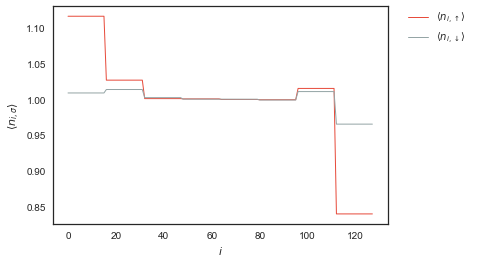

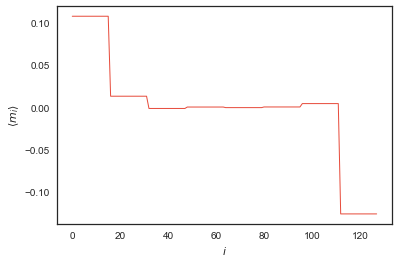

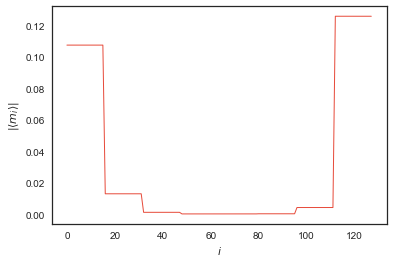

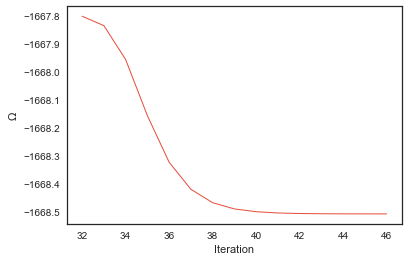

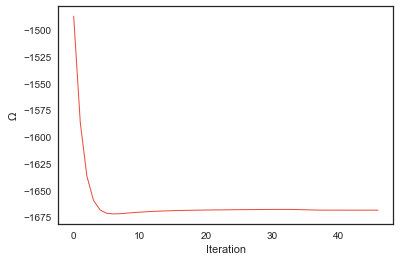

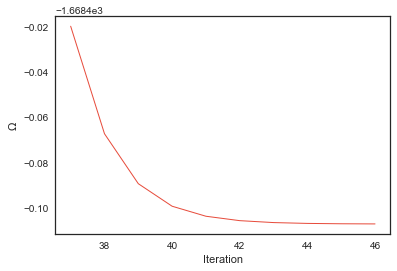

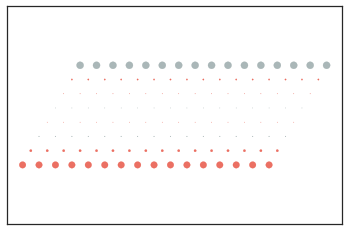

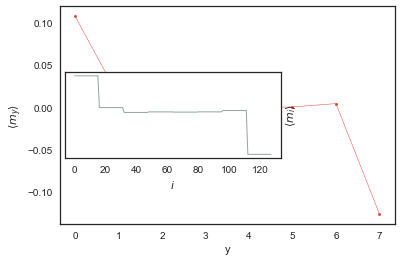

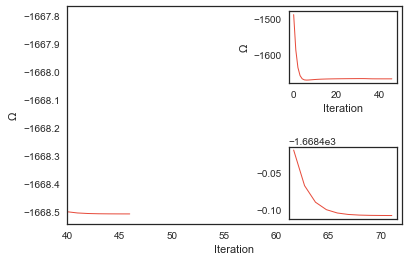

In [14]:
SAVEPLOTS = False
lastNit = 10
dotscale = 400
magInsetLoc = 6
plotTMD(nUp, nDown, energies, itSwitch, Nx, Ny, lastNit, lastIt, dotscale, magInsetLoc)
print("Final energy: ", energies[lastIt - 1])

In [ ]:
-1643.77426588

# Same thing, in momentum space (much more efficient)

In [28]:
Nx = 64
Ny = 16

N = nOrb * Nx * Ny

beta0 = 1.1 # must be > 1, otherwise beta decreases
betaTarget = 20 # 99999 means infty ( T = 0 )
beta = beta0 # beta starts as beta0
inftyCutOff = 100 # above it, beta is practically infinity
t = 1 # hopping normalized to one
U = 8 # on-site interaction
muPHS = 3.5 # chemical potential
mu = ( muPHS + U / 2 ) # corresponding Fermi energy not in PHS form
itMax = 100
it = 0
lbda = 0.5 / (1.1 * itMax) # the factor multiplied by itMax impedes P ( I ) < \delta
itSwitch = 0
dampFreq = 1
# lbda is a parameter that reduces weight
# on the density obtained in the previous iteration

# Set a seed for the random initial condition case
np.random.seed(1)

# AF initial condition

#nUp = np.array([1 , 0])
#for i in range(int(N/2) - 1):
#    nUp = np.concatenate((nUp, np.array([1, 0]) ))

#nDown = np.array([0, 1])
#for i in range(int(N/2) - 1):
#    nDown = np.concatenate((nDown, np.array([0, 1]) ))

# F initial condition

nUp = np.ones(3*Ny) - 0.1 * np.random.rand(3*Ny)

nDown = np.zeros(3*Ny) + 0.1 * np.random.rand(3*Ny)

# Hybrid initial condition

#nUp = np.zeros(3*Ny)
#nDown = np.zeros(3*Ny)

#spinFlipper = 0.5

#for i in range(3*Ny):
#    if i % (3) == 0:
#        spinFlipper *= -1
#    nUp[i] = 0.5 + spinFlipper *.1 * np.random.rand()
#    nDown[i] = 0.5 - spinFlipper *.1 * np.random.rand()

# Paramagnetic

#nUp = np.ones(3*Ny) - 0.1 * np.random.rand(3*Ny)

#nDown = np.ones(3*Ny) + 0.1 * np.random.rand(3*Ny)


# Initialize energies
energies = np.zeros(itMax)

# Tolerance

delta = 1e-15

deltaUp = delta + 1
deltaDown = delta + 1

eUp = np.zeros((Nx, 3*Ny))
wUp = np.zeros((Nx, 3*Ny, 3*Ny), dtype=np.complex64)
eDown = np.zeros((Nx, 3*Ny))
wDown = np.zeros((Nx, 3*Ny, 3*Ny), dtype=np.complex64)

ks = np.linspace(-np.pi,np.pi, num=Nx, endpoint=False)

while (it < itMax and \
      deltaUp > delta and\
      deltaDown > delta): # add condition of convergence
    
    # Annealing
    
    if (beta < inftyCutOff \
        and beta < betaTarget) : # > infty: zero temperature case
        beta = beta0 ** it
        if beta > betaTarget:
            itSwitch = it
            print(itSwitch)
            beta = betaTarget
    else:
        beta = betaTarget
        
    print('beta: ', beta)

    for kCount, k in enumerate(ks):
    
        C = - nUp * nDown
        
        K = Hribbon(k, Ny)
        
        Hup = K + U * np.eye(3*Ny) * ( nDown + C / 2 )
        Hdown = K + U * np.eye(3*Ny) * ( nUp + C / 2 )

        eUp[kCount, :], wUp[kCount, :, :] = la.eigh(Hup)
        eDown[kCount, :], wDown[kCount, :, :] = la.eigh(Hdown)

    nUpOld = nUp.copy()
    nDownOld = nDown.copy()

    for i in range(3*Ny):
        nUp[i] = 0
        nDown[i] = 0
        for n in range(3*Ny):
            for q in range(Nx):
                nUp[i] += abs(wUp[q, i, n])**2 * fermi(eUp[q, n].real, mu , beta)
                nDown[i] += abs(wDown[q, i, n])**2 * fermi(eDown[q, n].real, mu, beta)
        nUp[i] /= Nx
        nDown[i] /= Nx
        
    # Damping
    if it % dampFreq == 0:
        nUp = ( 1 / 2 + lbda * it ) * nUp\
        + ( 1 / 2 - lbda * it) * nUpOld
        nDown = ( 1 / 2 + lbda * it ) * nDown\
        + ( 1 / 2 - lbda * it) * nDownOld

    deltaUp = np.dot(nUp - nUpOld, nUp - nUpOld) / (3*Ny)**2  
    deltaDown = np.dot(nDown - nDownOld, nDown - nDownOld) / (3*Ny)**2
    
    # To check convergence
    print('delta nUp: ', deltaUp)
    print('delta nDown: ', deltaDown)
    # Check if chemical potential is imposing
    # the right number of particles
    print('<n>: ', (nUp.sum() + nDown.sum() ) / ( 3 * Ny ) )
    
    energies[it] = U * np.dot(nUp, nDown) / 3 / Ny + mu * (nUp + nDown).sum() / Ny/3\
    - 1 / beta * ( np.log( 1 + np.exp( - beta * ( eUp - mu ) ) ) + \
              np.log( 1 + np.exp( - beta * ( eDown - mu ) ) ) ).sum()
    
    it += 1
    
lastIt = it

beta:  1.0
delta nUp:  0.00205619445159
delta nDown:  0.000378979415635
<n>:  0.813506127379
beta:  1.1
delta nUp:  0.000525392548249
delta nDown:  0.00015107231435
<n>:  0.735220357893
beta:  1.2100000000000002
delta nUp:  0.000131827532576
delta nDown:  4.44962712577e-05
<n>:  0.698854682932
beta:  1.3310000000000004
delta nUp:  3.28476591206e-05
delta nDown:  1.35867074685e-05
<n>:  0.682052429772
beta:  1.4641000000000004
delta nUp:  8.27605589859e-06
delta nDown:  4.36195420821e-06
<n>:  0.674322654497
beta:  1.6105100000000006
delta nUp:  2.17566597699e-06
delta nDown:  1.49570830747e-06
<n>:  0.670786218205
beta:  1.7715610000000008
delta nUp:  6.29106014651e-07
delta nDown:  5.57522356275e-07
<n>:  0.669188837308
beta:  1.9487171000000012
delta nUp:  2.13133366e-07
delta nDown:  2.27677124416e-07
<n>:  0.668485265487
beta:  2.1435888100000016
delta nUp:  8.73337348827e-08
delta nDown:  1.01177743669e-07
<n>:  0.668189131468
beta:  2.357947691000002
delta nUp:  4.21168316575e-08

## Results

### Magnetization profile along y

Text(0.5,0,'$y$')

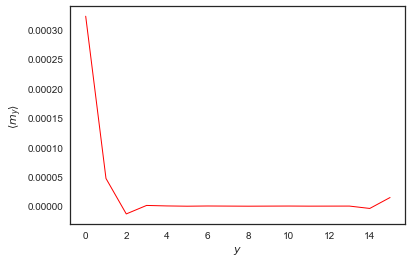

In [29]:
nUpSite = np.zeros(Ny)
nDownSite = np.zeros(Ny)
for i in range(Ny):    
    nUpSite[i] = nUp[nOrb * i] + nUp[nOrb * i + 1] + nUp[nOrb * i + 2]
    nDownSite[i] = nDown[nOrb * i] + nDown[nOrb * i + 1] + nDown[nOrb * i + 2]
    
plt.plot(Nx * (nUpSite-nDownSite), markersize=2, linewidth = 1, c = 'r')
plt.ylabel(r'$\left\langle m_y \right\rangle$')
plt.xlabel(r'$y$')

### Grandpotential minimization

Text(0.5,0,'Iteration')

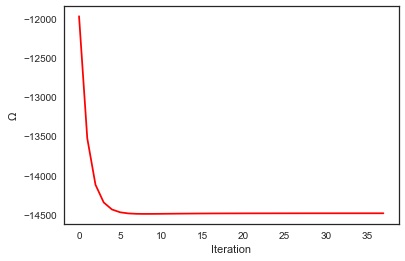

In [30]:
plt.plot(energies[:lastIt], c='r')
plt.ylabel(r'$\Omega$')
plt.xlabel('Iteration')